# Predict Salary

In [10]:
import glassdoor_scraper as gs
import pandas as pd
import requests
import io


## Import data

In [156]:
df=pd.read_csv('glassdoor_jobs.csv')
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa..."
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee"


## Data Cleaning

In [157]:
df.describe()

,Unnamed: 0,Rating,Founded
count,956.000000,956.000000,956.000000
mean,477.500000,3.601255,1774.605649
std,276.117729,1.067619,598.942517
min,0.000000,-1.000000,-1.000000
25%,238.750000,3.300000,1937.000000
50%,477.500000,3.800000,1992.000000
75%,716.250000,4.200000,2008.000000
max,955.000000,5.000000,2019.000000


### Salary Parsing

In [158]:
df=df[df['Salary Estimate']!='-1']
df.describe()

,Unnamed: 0,Rating,Founded
count,742.000000,742.000000,742.000000
mean,469.129380,3.618868,1837.154987
std,279.793117,0.801210,497.183763
min,0.000000,-1.000000,-1.000000
25%,221.500000,3.300000,1939.000000
50%,472.500000,3.700000,1988.000000
75%,707.750000,4.000000,2007.000000
max,955.000000,5.000000,2019.000000


In [159]:
df['hourly']=df['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
df['employer_provided']=df['Salary Estimate'].apply(lambda x: 1 if 'employer provided salary:' in x.lower() else 0)


In [160]:
salary=df['Salary Estimate'].apply(lambda x: x.split('(')[0])
minusKd=salary.apply(lambda x: x.replace('K','').replace('$',''))
minHr=minusKd.apply(lambda x: x.lower().replace('per hour','').replace('employer provided salary:',''))
minHr[:50]
df['min_salary']=minHr.apply(lambda x: int(x.split('-')[0]))
df['max_salary']=minHr.apply(lambda x: int(x.split('-')[1]))
df['avg_salary']=(df.min_salary+df.max_salary)/2
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,hourly,employer_provided,min_salary,max_salary,avg_salary
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,0,0,53,91,72.0
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,0,0,63,112,87.5
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,0,0,80,90,85.0
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",0,0,56,97,76.5
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",0,0,86,143,114.5


In [161]:
# Hourly wage to annual
df['min_salary']=df.apply(lambda x: x.min_salary*2 if x.hourly==1 else x.min_salary, axis=1)
df['max_salary']=df.apply(lambda x: x.max_salary*2 if x.hourly==1 else x.max_salary, axis=1)

### Company name text only

In [162]:
df['company_txt']=df.apply(lambda x: x['Company Name'] if x['Rating']<0 else x['Company Name'][:-3], axis=1)
df['company_txt']

0                          Tecolote Research\n
1      University of Maryland Medical System\n
2                                    KnowBe4\n
3                                       PNNL\n
4                         Affinity Solutions\n
                        ...                   
950                                      GSK\n
951                               Eventbrite\n
952           Software Engineering Institute\n
953                             Numeric, LLC\n
955             Riverside Research Institute\n
Name: company_txt, Length: 742, dtype: object

In [163]:
df['company_txt']=df.company_txt.apply(lambda x: x.replace('\n', ''))
df.company_txt

0                          Tecolote Research
1      University of Maryland Medical System
2                                    KnowBe4
3                                       PNNL
4                         Affinity Solutions
                       ...                  
950                                      GSK
951                               Eventbrite
952           Software Engineering Institute
953                             Numeric, LLC
955             Riverside Research Institute
Name: company_txt, Length: 742, dtype: object

### State field

In [164]:
df['job_state']=df['Location'].apply(lambda x: x.split(',')[1])
df['job_state']

0       NM
1       MD
2       FL
3       WA
4       NY
      ... 
950     MA
951     TN
952     PA
953     PA
955     OH
Name: job_state, Length: 742, dtype: object

In [165]:
df['same_state']=df.apply(lambda x: 1 if x.Location==x.Headquarters else 0, axis=1)
#df.same_state

In [166]:
# Fix state Los Angeles
df.job_state=df.job_state.apply(lambda x: x.strip() if x.strip().lower() != 'los angeles' else 'CA')
#df.drop('job_state', inplace=True, axis=1)

### Age of company

In [167]:
df['age']=df.Founded.apply(lambda x: x if x<1 else 2021 - x)
df.age

0       48
1       37
2       11
3       56
4       23
      ... 
950    191
951     15
952     37
953     -1
955     54
Name: age, Length: 742, dtype: int64

### Job Description

In [168]:
df['python_yn']=df['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
df['R_yn']=df['Job Description'].apply(lambda x: 1 if 'r studio' in x.lower() or 'r-studio' in x.lower() else 0)
df['spark_yn']=df['Job Description'].apply(lambda x: 1 if 'spark' in x.lower() else 0)
df['aws_yn']=df['Job Description'].apply(lambda x: 1 if 'aws' in x.lower() else 0)
df.aws_yn.value_counts()
df['excel_yn']=df['Job Description'].apply(lambda x: 1 if 'excel' in x.lower() else 0)

In [169]:
# Job description length
df['desc_len']=df['Job Description'].apply(lambda x: len(x))

### Competitors

In [170]:
df['num_comp']=df['Competitors'].apply(lambda x: len(x.split(',')) if x!= '-1' else 0)

### Job Title

In [171]:

def title_simplifier(title):
    if 'data scientist' in title.lower():
        return 'data scientist'
    elif 'data engineer' in title.lower():
        return 'data engineer'
    elif 'analyst' in title.lower():
        return 'analyst'
    elif 'machine learning' in title.lower():
        return 'mle'
    elif 'manager' in title.lower():
        return 'manager'
    elif 'director' in title.lower():
        return 'director'
    else:
        return 'na'
    
def seniority(title):
    if 'sr' in title.lower() or 'senior' in title.lower() or 'sr' in title.lower() or 'lead' in title.lower() or 'principal' in title.lower():
            return 'senior'
    elif 'jr' in title.lower() or 'jr.' in title.lower():
        return 'jr'
    else:
        return 'na'

In [172]:
df['job_simp']=df['Job Title'].apply(title_simplifier)
df.job_simp.value_counts()

data scientist    279
na                184
data engineer     119
analyst           102
mle                22
manager            22
director           14
Name: job_simp, dtype: int64

In [173]:
df['seniority']=df['Job Title'].apply(seniority)
df.seniority.value_counts()

na        520
senior    220
jr          2
Name: seniority, dtype: int64

### Drop Unnamed: 0 Column

In [174]:
df_out =df.drop(['Unnamed: 0'], axis=1)
#df_out

### Export Data cleaned

In [72]:
df_out.to_csv('salary_data_cleaned.csv', index=False)

## Exploratory Data Analysis

In [73]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [74]:
df=pd.read_csv('salary_data_cleaned.csv')

In [75]:
df.describe()

,Rating,Founded,hourly,employer_provided,min_salary,max_salary,avg_salary,same_state,age,python_yn,R_yn,spark_yn,aws_yn,excel_yn,desc_len,num_comp
count,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,3.618868,1837.154987,0.032345,0.022911,74.719677,128.149596,100.626011,0.557951,47.524259,0.528302,0.002695,0.225067,0.237197,0.522911,3869.545822,1.053908
std,0.801210,497.183763,0.177034,0.149721,30.980593,45.220324,38.855948,0.496965,53.839080,0.499535,0.051882,0.417908,0.425651,0.499812,1521.495868,1.384239
min,-1.000000,-1.000000,0.000000,0.000000,15.000000,16.000000,13.500000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000
25%,3.300000,1939.000000,0.000000,0.000000,52.000000,96.000000,73.500000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2801.000000,0.000000
50%,3.700000,1988.000000,0.000000,0.000000,69.500000,124.000000,97.500000,1.000000,25.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3731.000000,0.000000
75%,4.000000,2007.000000,0.000000,0.000000,91.000000,155.000000,122.500000,1.000000,60.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4740.000000,3.000000
max,5.000000,2019.000000,1.000000,1.000000,202.000000,306.000000,254.000000,1.000000,277.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10051.000000,4.000000


In [76]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark_yn', 'aws_yn', 'excel_yn', 'desc_len', 'num_comp', 'job_simp',
       'seniority'],
      dtype='object')

<AxesSubplot:>

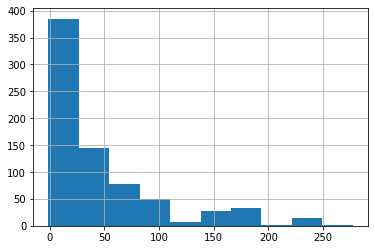

In [77]:
df.age.hist()

<AxesSubplot:>

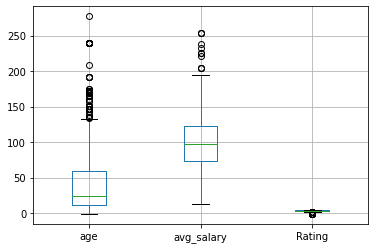

In [78]:
df.boxplot(column=['age','avg_salary','Rating'])

<AxesSubplot:>

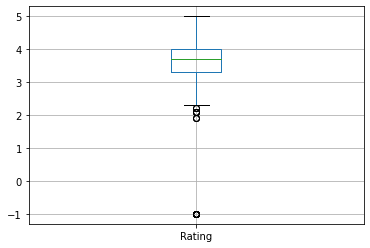

In [79]:
df.boxplot(column=['Rating'])

In [80]:
df[['age','avg_salary','Rating','desc_len']].corr()

,age,avg_salary,Rating,desc_len
age,1.000000,0.019574,0.023162,0.164188
avg_salary,0.019574,1.000000,0.013492,0.078808
Rating,0.023162,0.013492,1.000000,-0.012281
desc_len,0.164188,0.078808,-0.012281,1.000000


<AxesSubplot:>

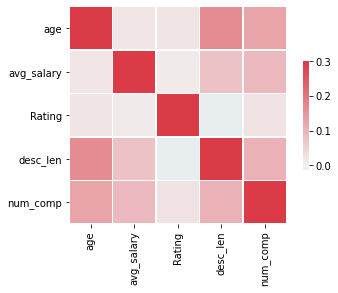

In [81]:
cmap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(df[['age','avg_salary','Rating','desc_len','num_comp']].corr(),vmax=.3,center=0,square=True,cmap=cmap,linewidth=.5,cbar_kws={"shrink":.5})

In [82]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark_yn', 'aws_yn', 'excel_yn', 'desc_len', 'num_comp', 'job_simp',
       'seniority'],
      dtype='object')

In [152]:
dfCat=df[['Location', 'Headquarters', 'Size','Type of ownership', 'Industry', 'Sector', 'Revenue','company_txt','job_state','same_state','python_yn', 'R_yn', 'spark_yn',
       'aws_yn', 'excel_yn','job_simp', 'seniority']]

graph for Location: total= 20


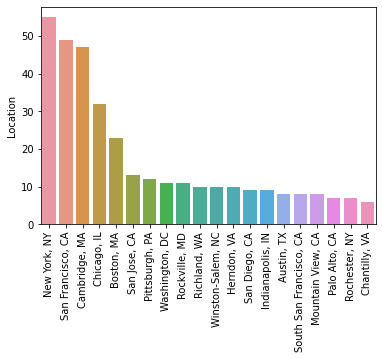

graph for Headquarters: total= 20


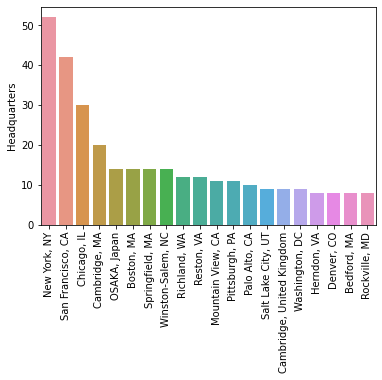

graph for Size: total= 9


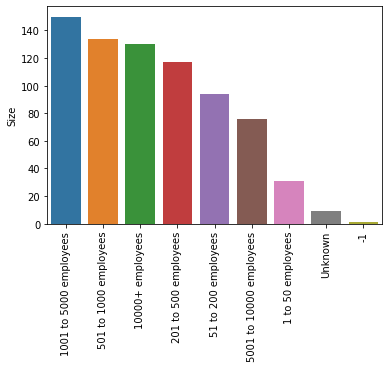

graph for Type of ownership: total= 11


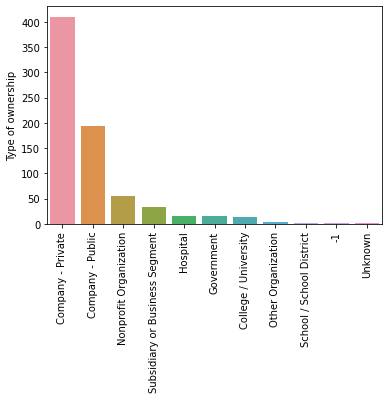

graph for Industry: total= 20


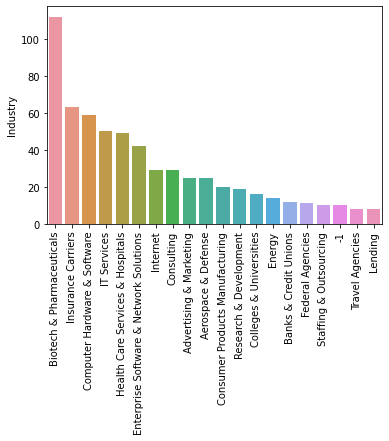

graph for Sector: total= 20


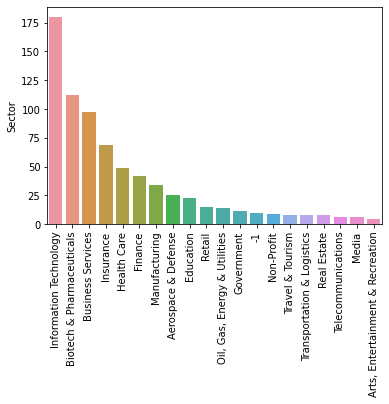

graph for Revenue: total= 14


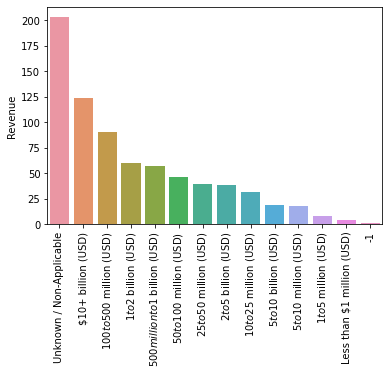

graph for company_txt: total= 20


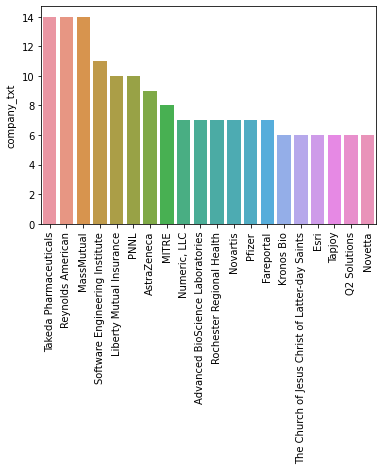

graph for job_state: total= 20


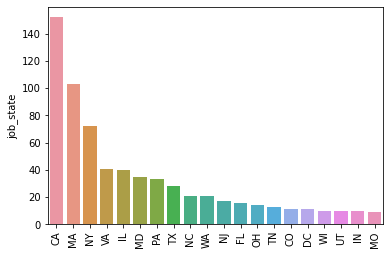

graph for same_state: total= 2


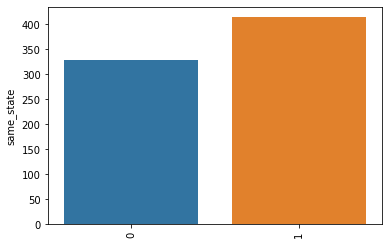

graph for python_yn: total= 2


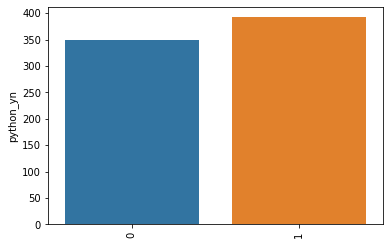

graph for R_yn: total= 2


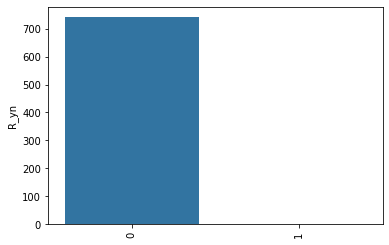

graph for spark_yn: total= 2


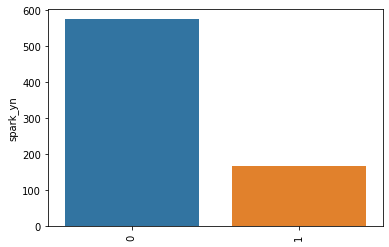

graph for aws_yn: total= 2


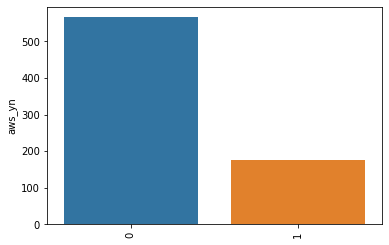

graph for excel_yn: total= 2


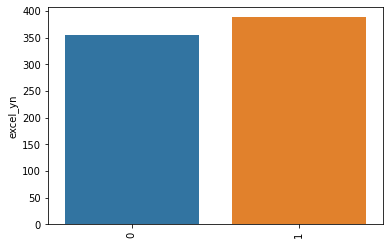

graph for job_simp: total= 7


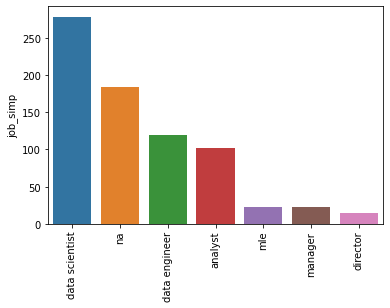

graph for seniority: total= 3


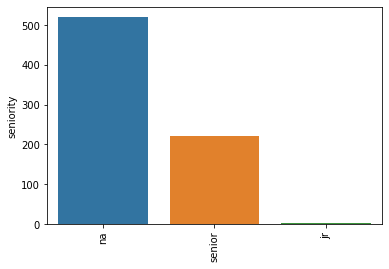

In [153]:
for i in dfCat.columns:
    catNum=dfCat[i].value_counts()[:20]
    print("graph for %s: total= %d" % (i,len(catNum)))
    chart=sns.barplot(x=catNum.index, y=catNum)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()

graph for Location: total= 20


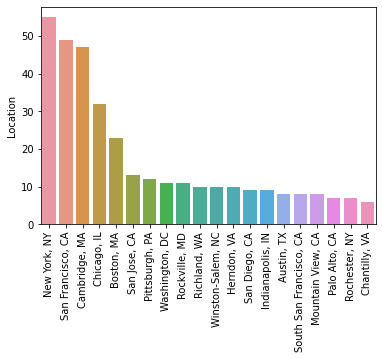

graph for Headquarters: total= 20


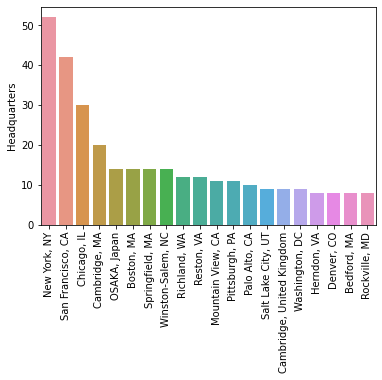

graph for company_txt: total= 20


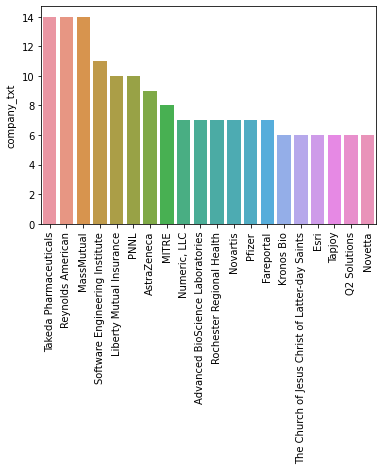

In [154]:
for i in dfCat[['Location','Headquarters','company_txt']]:
    catNum=dfCat[i].value_counts()[:20]
    print("graph for %s: total= %d" % (i,len(catNum)))
    chart=sns.barplot(x=catNum.index, y=catNum)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()

In [85]:
pd.pivot_table(df, index='job_simp', values='avg_salary')

,avg_salary
job_simp,
analyst,65.857843
data engineer,105.403361
data scientist,117.564516
director,168.607143
manager,84.022727
mle,126.431818
na,84.853261


In [86]:
pd.pivot_table(df, index=['job_simp','seniority'], values='avg_salary')

avg_salary
job_simp      seniority            
analyst       jr          56.500000
              na          61.155405
              senior      79.092593
data engineer na          96.701220
              senior     124.689189
...                             ...
manager       na          84.022727
mle           na         119.133333
              senior     142.071429
na            na          73.988189
              senior     109.061404

[14 rows x 1 columns]

In [87]:
pd.set_option('display.max_rows',10)
pd.pivot_table(df, index=['job_state','job_simp'], values='avg_salary',aggfunc='count').sort_values('job_state',ascending=False)

avg_salary
job_state job_simp                  
WI        na                       4
          data scientist           3
          analyst                  3
WA        na                       1
          data scientist          17
...                              ...
AZ        analyst                  1
          na                       2
AL        na                       2
          data engineer            1
          analyst                  5

[114 rows x 1 columns]

In [88]:
pd.pivot_table(df[df.job_simp=='data scientist'], index=['job_state'], values='avg_salary').sort_values('avg_salary',ascending=False)

,avg_salary
job_state,
DC,149.000000
CA,142.522059
UT,140.500000
MO,127.666667
IL,117.233333
...,...
KY,84.000000
CT,84.000000
GA,81.333333


In [89]:
dfPivots = df[['Rating', 'Industry', 'Sector', 'Revenue', 'num_comp', 'hourly', 'employer_provided', 'python_yn', 'R_yn', 'spark_yn', 'aws_yn', 'excel_yn', 'Type of ownership','avg_salary']]
for i in dfPivots.columns:
    print(pd.pivot_table(dfPivots,index=i, values='avg_salary').sort_values('avg_salary',ascending=False))

        avg_salary
Rating            
-1.0    136.181818
 5.0    134.700000
 2.5    120.000000
 4.5    117.714286
 4.1    116.368421
...            ...
 2.7     83.250000
 2.3     81.500000
 2.9     81.138889
 4.8     80.277778
 2.4     60.214286

[31 rows x 1 columns]
                                          avg_salary
Industry                                            
Other Retail Stores                       163.500000
Motion Picture Production & Distribution  146.000000
Financial Analytics & Research            145.125000
Health, Beauty, & Fitness                 139.500000
Telecommunications Services               131.500000
...                                              ...
Architectural & Engineering Services       50.500000
Gambling                                   48.500000
Social Assistance                          48.166667
Telecommunications Manufacturing           44.000000
Construction                               26.500000

[60 rows x 1 columns]
                  

ValueError: Grouper for 'avg_salary' not 1-dimensional

In [ ]:
pd.pivot_table(df_pivots, index='Revenue', columns='python_yn',values='avg_salary', aggfunc='count')

## Model Building

In [ ]:
import numpy as np

* Choose relevant columns
* Get dummy data
* Train test split
* Multiple linear regression
* Lasso regression
* Random forest
* Tune models GridsearchCV
* Test ensembles


### Choose relevant columns

In [92]:
dfModel=df[['avg_salary','Rating', 'Size', 'Type of ownership','Industry', 'Sector', 'Revenue', 'num_comp', 'hourly', 'employer_provided', 'job_state','same_state','age','python_yn','spark_yn','aws_yn','excel_yn','job_simp','seniority','desc_len']]

### Get dummy data

In [93]:
dfDum=pd.get_dummies(dfModel)

### Train test split

In [94]:
from sklearn.model_selection import train_test_split

x=dfDum.drop('avg_salary',axis=1)
y=dfDum.avg_salary.values

xTrain, xTest, yTrain, yTest= train_test_split(x,y,test_size=0.2, random_state=42)

### Statsmodels

In [97]:
import statsmodels.api as sm 

x_sm = x = sm.add_constant(x)

In [99]:
SMModel=sm.OLS(y, x_sm)
SMModel.fit().summary()

.498      0.619     -14.280       8.501
Size_1001 to 5000 employees                           6.1313      3.879      1.581      0.114      -1.486      13.749
Size_201 to 500 employees                             2.2518      3.873      0.581      0.561      -5.355       9.858
Size_5001 to 10000 employees                         -3.8772      5.441     -0.713      0.476     -14.564       6.809
Size_501 to 1000 employees                            2.1756      4.059      0.536      0.592      -5.797      10.148
Size_51 to 200 employees                              4.1939      4.422      0.948      0.343      -4.490      12.878
Size_Unknown                                         20.9068     13.992      1.494      0.136      -6.573      48.386
Type of ownership_-1                                 13.6141      8.629      1.578      0.115      -3.333      30.561
Type of ownership_College / University                6.4397     17.738      0.363      0.717     -28.397      41.276
Type of ownership_Company - Private                   8.5908      5.239      1.640      0.102      -1.698      18.880
Type of ownership_Company - Public                   13.2822      5.699      2.331      0.020       2.090      24.475
Type of ownership_Government                        -15.3380     15.289     -1.003      0.316     -45.365      14.689
Type of ownership_Hospital                           -7.1449      9.965     -0.717      0.474     -26.715      12.425
Type of ownership_Nonprofit Organization             -9.8059      6.711     -1.461      0.145     -22.986       3.374
Type of ownership_Other Organization                 -5.9809     14.342     -0.417      0.677     -34.148      22.187
Type of ownership_School / School District           -5.9859     23.791     -0.252      0.801     -52.709      40.737
Type of ownership_Subsidiary or Business Segment     12.7894      6.928      1.846      0.065      -0.816      26.395
Type of ownership_Unknown                            33.1535     28.609      1.159      0.247     -23.032      89.339
Industry_-1                                           5.8360      7.935      0.735      0.462      -9.748      21.420
Industry_Accounting                                   2.5117     13.486      0.186      0.852     -23.973      28.997
Industry_Advertising & Marketing                     11.6559      5.976      1.951      0.052      -0.080      23.392
Industry_Aerospace & Defense                          5.5827      3.109      1.795      0.073      -0.524      11.689
Industry_Architectural & Engineering Services       -32.4273     15.935     -2.035      0.042     -63.723      -1.131
Industry_Auctions & Galleries                         9.2853     22.877      0.406      0.685     -35.644      54.214
Industry_Banks & Credit Unions                      -16.9613      8.046     -2.108      0.035     -32.764      -1.159
Industry_Beauty & Personal Accessories Stores        15.4286     21.561      0.716      0.475     -26.916      57.774
Industry_Biotech & Pharmaceuticals                    6.4285      2.045      3.144      0.002       2.413      10.444
Industry_Brokerage Services                          28.1129     15.522      1.811      0.071      -2.371      58.597
Industry_Colleges & Universities                     10.9554     12.990      0.843      0.399     -14.555      36.466
Industry_Computer Hardware & Software                -0.9254      3.250     -0.285      0.776      -7.308       5.457
Industry_Construction                               -15.5542     10.562     -1.473      0.141     -36.297       5.188
Industry_Consulting                                  12.9327      5.901      2.192      0.029       1.344      24.521
Industry_Consumer Product Rental                     -2.4487     13.017     -0.188      0.851     -28.013      23.116
Industry_Consumer Products Manufacturing             13.8230      9.858      1.402      0.161      -5.537      33.183
Industry_Department, Clothing, & Shoe Stores          4.7390     1

### Multiple linear regressor

In [150]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

LRModel = LinearRegression()
LRModel.fit(xTrain, yTrain)
scores=cross_val_score(LRModel, xTrain, yTrain, cv=4, scoring="neg_mean_absolute_error")
print("mean MAE: ", scores.mean())
print(scores)

mean MAE:  -19.771947992463588
[-19.75660317 -19.4916527  -19.6342547  -20.2052814 ]


### Lasso regressor

In [137]:
from sklearn.linear_model import Lasso

LModel=Lasso(alpha=0.13)
LModel.fit(xTrain, yTrain)
scores=cross_val_score(LModel, xTrain, yTrain, cv=3, scoring="neg_mean_absolute_error")
print("mean MAE: ", scores.mean())

mean MAE:  -19.25938252046299


In [123]:
alpha=[]
error=[]

for i in range(1,100):
    alpha.append(i/100)
    LAlphaModel=Lasso(alpha=i/100)
    error.append(np.mean(cross_val_score(LAlphaModel, xTrain, yTrain, 
                        cv=3,scoring="neg_mean_absolute_error")))



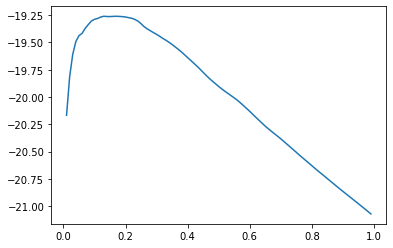

In [124]:
plt.plot(alpha, error)

In [127]:
err=tuple(zip(alpha,error))
dfErr=pd.DataFrame(err,columns=['alpha','error'])
dfErr[dfErr.error==max(dfErr.error)]

,alpha,error
12,0.13,-19.259383


### Random forest regressor

In [128]:
from sklearn.ensemble import RandomForestRegressor

RFModel=RandomForestRegressor()
scores=cross_val_score(RFModel, xTrain, yTrain, cv=3, scoring="neg_mean_absolute_error")
print("mean MAE: ", scores.mean())

mean MAE:  -14.997449324035621


### Tunning

In [131]:
from sklearn.model_selection import GridSearchCV

parameters= {'n_estimators': range(10,300,10), 'criterion':('mse','mae'), 'max_features':('auto', 'sqrt', 'log2')}
gs=GridSearchCV(RFModel,parameters,scoring="neg_mean_absolute_error", cv=3)
gs.fit(xTrain,yTrain)


GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'criterion': ('mse', 'mae'),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'n_estimators': range(10, 300, 10)},
             scoring='neg_mean_absolute_error')

In [133]:
print(gs.best_score_)
print(gs.best_estimator_)

-14.832663129665034
RandomForestRegressor(criterion='mae', n_estimators=280)


### Testing

In [151]:
from sklearn.metrics import mean_absolute_error

predLRModel=LRModel.predict(xTest)
predLModel=LModel.predict(xTest)
predRF=gs.best_estimator_.predict(xTest)

errorLRModel=mean_absolute_error(yTest,predLRModel)
errorLModel=mean_absolute_error(yTest,predLModel)
errorRF=mean_absolute_error(yTest,predRF)

print(errorLRModel)
print(errorLModel)
print(errorRF)
print(mean_absolute_error(yTest, (predLModel+predRF)/2))

214782617.86556616
19.665335557477682
11.209587727708533
14.951552671437835
